In [1]:
import numpy as np


def find_nearest_vector(array, value):
    """Find the nearest vector in 'array' to 'value'."""
    idx = np.linalg.norm(array - value, axis=1).argmin()
    return array[idx]


# Example codebook with 4 vectors, each of dimension 3
codebook = np.array([
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0],
    [10.0, 11.0, 12.0]
])

# A sample continuous latent vector that we want to quantize
continuous_vector = np.array([6.5, 7.5, 8.5])

# Find the nearest codebook vector
nearest_vector = find_nearest_vector(codebook, continuous_vector)

print("Continuous Vector:", continuous_vector)
print("Nearest Codebook Vector:", nearest_vector)

Continuous Vector: [6.5 7.5 8.5]
Nearest Codebook Vector: [7. 8. 9.]


In [2]:
import numpy as np


def encoder_network(input_data):
    # Assuming the latent space is 2-dimensional for simplicity
    means = np.mean(input_data, axis=1) + np.random.normal(0, 0.1, size=input_data.shape[0])
    variances = np.var(input_data, axis=1) + np.random.normal(0, 0.1, size=input_data.shape[0])
    return means, variances


# Example input data: 5 samples, each with 4 features
input_data = np.array([
    [0.1, 0.2, 0.3, 0.4],
    [0.5, 0.6, 0.7, 0.8],
    [0.9, 1.0, 1.1, 1.2],
    [1.3, 1.4, 1.5, 1.6],
    [1.7, 1.8, 1.9, 2.0]
])

# Encoder output
means, variances = encoder_network(input_data)
print("Means of z given x:\n", means)
print("Variances of z given x:\n", variances)

Means of z given x:
 [0.11900197 0.74350477 1.05821735 1.46144721 1.92372244]
Variances of z given x:
 [-0.14969972  0.10835411  0.10410374 -0.24581156  0.10788374]


In [3]:
import numpy as np


def find_nearest_embedding(z_e, embeddings):
    """Find the nearest embedding vector."""
    distances = np.linalg.norm(embeddings - z_e, axis=1)
    nearest_idx = np.argmin(distances)
    return embeddings[nearest_idx], nearest_idx


# Define a set of embedding vectors (K=3, D=2 for simplicity)
embeddings = np.array([
    [1.0, 2.0],
    [2.5, 3.5],
    [0.5, 1.5]
])

# Output of the encoder (a continuous vector)
z_e = np.array([2.1, 3.1])

# Find the nearest embedding vector
nearest_embedding, idx = find_nearest_embedding(z_e, embeddings)
print("Nearest Embedding Vector:", nearest_embedding, "Index:", idx)

Nearest Embedding Vector: [2.5 3.5] Index: 1


In [1]:
from datasets import load_dataset
from vq_vae.features import VQVAEProcessor, VQVAEFeatureExtractor
from vq_vae.models import SpeechVQVAE
import torch

# Instantiate the feature extractor and processor
feature_extractor = VQVAEFeatureExtractor(sampling_rate=22050, mel_norm_file='../mel_stats.pth', max_duration=10)
processor = VQVAEProcessor(feature_extractor)

# Load your Bambara TTS dataset
dataset = load_dataset("oza75/bambara-tts", "denoised")
dataset

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/18 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'bambara', 'french', 'duration', 'speaker_embeddings', 'speaker_id'],
        num_rows: 30765
    })
})

In [2]:
batch = processor(dataset['train'][:1])
inputs, attention_masks = batch["mel_spectrogram"], batch["attention_mask"]
inputs.shape

torch.Size([1, 80, 862])

In [12]:
inputs[0][:, attention_masks[0].sum(dim=0).int()].shape

torch.Size([80, 2584])

In [4]:
inputs.view(inputs.shape[0], 1, inputs.shape[1], inputs.shape[2])[0][0].shape

torch.Size([80, 2584])

In [11]:
model = SpeechVQVAE(
    in_channels=1,
    out_channels=1,
    down_block_types=("DownEncoderBlock2D",),
    up_block_types=("UpDecoderBlock2D",),
    block_out_channels=(64,),
    layers_per_block=1,
    act_fn="silu",
    latent_channels=1,
    sample_size=32,
    num_vq_embeddings=256,
    norm_num_groups=32,
    vq_embed_dim=None,
    scaling_factor=0.18215,
    norm_type="group"
)

outputs = model(
    inputs.view(inputs.shape[0], 1, inputs.shape[1], inputs.shape[2]),
    return_dict=False
)

In [12]:
outputs

(tensor([[[[ 1.0645,  0.7793,  1.2736,  ...,  0.6000,  0.8310,  0.2149],
           [ 1.5570,  1.7963,  0.6477,  ..., -0.4081, -0.7912,  0.7684],
           [ 2.1340,  0.3237, -2.8200,  ..., -0.7536, -0.2962,  0.4293],
           ...,
           [-0.6538,  4.5426,  0.1162,  ...,  1.2093,  1.9380,  0.9037],
           [-0.5159,  2.6528, -0.8582,  ...,  0.1875, -0.7324,  0.2578],
           [-0.9014, -0.0694,  0.2397,  ...,  0.3537,  1.0706,  0.9324]]]],
        grad_fn=<ConvolutionBackward0>),
 tensor([[[[0.9740, 0.9450, 0.9341,  ..., 0.9442, 0.9311, 0.9341],
           [0.9621, 0.9227, 0.9336,  ..., 0.9399, 0.9126, 0.9546],
           [0.9741, 0.9175, 0.9306,  ..., 0.9514, 0.9171, 0.9605],
           ...,
           [0.9819, 0.9218, 0.9428,  ..., 0.9360, 0.9315, 0.9270],
           [0.9644, 0.9250, 0.9420,  ..., 0.9440, 0.9441, 0.9419],
           [0.9740, 0.9376, 0.9590,  ..., 0.9396, 0.9502, 0.9318]]]],
        grad_fn=<ConvolutionBackward0>),
 tensor([[[[ 0.3065, -0.0077, -0.1260,  

In [5]:
import torch.nn.functional as F

def masked_vq_vae_loss(x, x_recon, z_e, z_q, attention_mask, beta=0.25):
    """
    Compute the masked VQ-VAE loss.

    Args:
        x (torch.Tensor): Original input.
        x_recon (torch.Tensor): Reconstructed input.
        z_e (torch.Tensor): Encoder output (continuous).
        z_q (torch.Tensor): Quantized encoder output (discrete).
        attention_mask (torch.Tensor): Mask indicating valid parts of the input.
        beta (float): Hyperparameter for commitment loss.

    Returns:
        torch.Tensor: Total VQ-VAE loss with masking.
    """
    # Ensure the attention mask has the same shape as the inputs
    attention_mask = attention_mask.expand_as(x)

    # Reconstruction loss with masking
    recon_loss = F.mse_loss(x_recon * attention_mask, x * attention_mask, reduction='none')
    recon_loss = recon_loss.sum() / attention_mask.sum()

    # VQ loss with masking
    vq_loss = F.mse_loss(z_q.detach() * attention_mask, z_e * attention_mask, reduction='none')
    vq_loss = vq_loss.sum() / attention_mask.sum()

    # Commitment loss with masking
    commit_loss = F.mse_loss(z_q * attention_mask, z_e.detach() * attention_mask, reduction='none')
    commit_loss = commit_loss.sum() / attention_mask.sum()

    # Total loss
    loss = recon_loss + vq_loss + beta * commit_loss

    return loss

In [18]:
masked_vq_vae_loss(
    inputs.view(inputs.shape[0], 1, inputs.shape[1], inputs.shape[2]),
    outputs[0],
    outputs[2],
    outputs[1],
    attention_masks.view(inputs.shape[0], 1, inputs.shape[1], inputs.shape[2]),
    beta=0.1
)

tensor(4.1563, grad_fn=<AddBackward0>)

In [13]:
outputs[1].shape

torch.Size([1, 1, 80, 862])

In [3]:
import matplotlib.pyplot as plt
from IPython.display import Audio


def display_audio_and_spectrogram(audio, feature_extractor):
    """
    Display the raw audio waveform and its corresponding Mel spectrogram.

    Args:
        audio (dict): Raw audio waveform.
        feature_extractor (CustomFeatureExtractor): Feature extractor to process the audio.
    """
    waveform, sample_rate = audio['array'], audio['sampling_rate']
    # Ensure audio is a tensor
    if not isinstance(waveform, torch.Tensor):
        waveform = torch.tensor(waveform, dtype=torch.float32)

    # Add batch dimension if necessary
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0)

    # Extract Mel spectrogram
    features = feature_extractor([audio])
    mel_spectrogram = features["mel_spectrogram"]

    # Display the raw audio waveform
    plt.figure(figsize=(10, 4))
    plt.plot(waveform.squeeze().numpy())
    plt.title("Raw Audio Waveform")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()

    # Display the Mel spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram.squeeze().numpy(), origin="lower", aspect="auto", interpolation="nearest")
    plt.title("Mel Spectrogram")
    plt.xlabel("Time Frame")
    plt.ylabel("Mel Frequency Bin")
    plt.colorbar(format="%+2.0f dB")
    plt.show()

    # Play the audio
    display(Audio(waveform.squeeze().numpy(), rate=sample_rate))

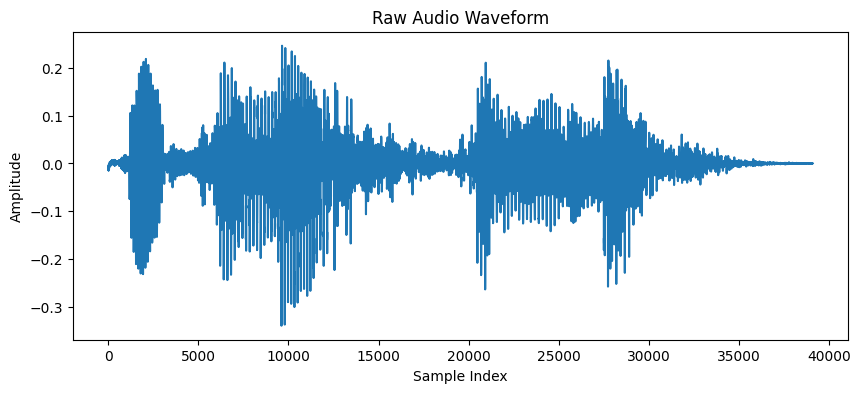

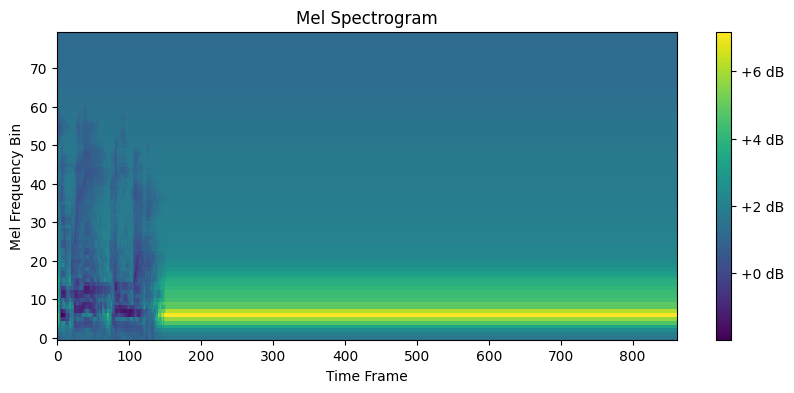

In [4]:
display_audio_and_spectrogram(dataset['train'][10]['audio'], feature_extractor=feature_extractor)

In [6]:
std

tensor([2.8235e-02, 2.3697e-02, 6.4896e-02, 3.2347e-01, 1.0867e+00, 2.5342e+00,
        3.1943e+00, 4.0386e+00, 6.1574e+00, 7.4380e+00, 5.1418e+00, 4.5580e+00,
        4.9779e+00, 7.3149e+00, 5.8472e+00, 5.8116e+00, 7.0341e+00, 6.2138e+00,
        7.2656e+00, 5.6003e+00, 3.7691e+00, 2.9650e+00, 2.6288e+00, 1.3473e+00,
        6.4328e-01, 6.9954e-01, 5.4887e-01, 2.9528e-01, 1.6031e-01, 1.5943e-01,
        2.8354e-01, 5.8059e-01, 3.0676e-01, 2.2232e-01, 1.8111e-01, 1.9595e-01,
        2.3712e-01, 2.4252e-01, 1.5067e-01, 1.1525e-01, 7.9304e-02, 4.4012e-02,
        3.6260e-02, 3.8811e-02, 2.8947e-02, 2.8336e-02, 2.4699e-02, 1.7877e-02,
        1.3161e-02, 1.0564e-02, 1.6556e-02, 5.4249e-03, 3.3774e-03, 1.9491e-03,
        1.3824e-03, 7.9441e-04, 3.2770e-04, 2.7844e-04, 2.2655e-04, 1.6045e-04,
        8.7492e-05, 3.3027e-05, 3.2143e-05, 3.4888e-05, 3.3771e-05, 1.9904e-05,
        1.4347e-05, 3.6073e-05, 3.5581e-05, 3.4933e-05, 2.3007e-05, 3.2570e-05,
        3.1310e-05, 4.7816e-05, 7.9297e-